# Natural Language Processing for the Fake News Challenge

## Main Imports

In [101]:
import torch
import string
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

!pip install transformers
import transformers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Set up the data for preprocessing
### Load the data

In [107]:
main_path = '/content/drive/My Drive/University Work/Year 4/Natural Language Processing/'
data_folder_name = 'data/'

train_body_filename = 'train_bodies.csv'
train_stance_filename = 'train_stances.csv'
test_body_filename = 'competition_test_bodies.csv'
test_stance_filename = 'competition_test_stances.csv'

train_body_path = main_path + data_folder_name + train_body_filename 
train_stance_path = main_path + data_folder_name + train_stance_filename
test_body_path = main_path + data_folder_name + test_body_filename
test_stance_path = main_path + data_folder_name + test_stance_filename

train_body_data = pd.read_csv(train_body_path)
train_stance_data = pd.read_csv(train_stance_path)
test_body_data = pd.read_csv(test_body_path)
test_stance_data = pd.read_csv(test_stance_path)

### Preprocessing by removing stopwords and punctuation and applying stemming

In [4]:
def preprocess(text):

    text = nltk.tokenize.word_tokenize(text)
    text = [word for word in text if word not in nltk.corpus.stopwords.words('english')]
    text = (" ").join(text)

    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)

    ps = nltk.stem.PorterStemmer()
    text = nltk.tokenize.word_tokenize(text)

    text = [ps.stem(word) for word in text]
    text = (" ").join(text)

    return text

In [5]:
train_body_data['articleBody'] = train_body_data['articleBody'].apply(lambda x: preprocess(x))
train_stance_data['Headline'] = train_stance_data['Headline'].apply(lambda x: preprocess(x))
test_body_data['articleBody'] = test_body_data['articleBody'].apply(lambda x: preprocess(x))
test_stance_data['Headline'] = test_stance_data['Headline'].apply(lambda x: preprocess(x))

### Merge the data based on the Body ID to get one dataframe containing the corresponding Headlines and Article Bodies with a Relevance column

In [6]:
train_total_data = pd.merge(train_body_data, train_stance_data, on='Body ID')
train_total_data['Relevance'] = np.where(train_total_data['Stance'] == 'unrelated', 0, 1)

test_total_data = pd.merge(test_body_data, test_stance_data, on='Body ID')
test_total_data['Relevance'] = np.where(test_total_data['Stance'] == 'unrelated', 0, 1)

train_total_data.sample(10)

,Body ID,articleBody,Headline,Stance,Relevance
30315,1689,islam state fighter match ebola the world heal...,thi letter To parent from A 1970 lego set cont...,unrelated,0
5852,344,while child entrepreneur becom increasingli co...,kidnap nigerian schoolgirl govern claim ceasef...,unrelated,0
4882,286,A rumor tuesday claim appl s upcom appl watch ...,In moscow polic look felon cut male genit,unrelated,0
10152,625,scottish peopl strongest stomach world – even ...,kim dine with ME porki presid kim jongun open ...,discuss,1
17146,1012,rep duncan hunter rca told greta van susteren ...,macaulay culkin dead hoax fake death report sp...,unrelated,0
2538,137,30yearold moscow resid hospit wound intim natu...,christian bale Wo nt play steve job after all,unrelated,0
17853,1040,mashabl report islam state milit mosul contrac...,there limit deprav islam state feed mother son,unrelated,0
15001,900,A hoax stori alleg british graffiti artist ban...,wa alleg audio michael brown shoot cnn hoax,unrelated,0
1993,115,afghanistan veteran sam arnold upload spinechi...,new io 8 bug delet icloud document,unrelated,0
36423,1946,A texa nation guard soldier scan mexican side ...,homeland secur say terrorist nt cross usmexico...,discuss,1


### Splitting the dataset into train and validation sets

In [32]:
train_input_columns = train_total_data[['Headline', 'articleBody']]
test_input_columns = test_total_data[['Headline', 'articleBody']]
target = 'Relevance'
X_train, X_val, y_train, y_val = train_test_split(train_input_columns, train_total_data[target].values, test_size=0.20, random_state=0)

X_test = test_total_data[['Headline', 'articleBody']]
y_test = test_total_data[['Relevance']].to_numpy().ravel()

# check the size of our datasets
print('Size of training set:', X_train.shape)
print('Size of validation set:', X_val.shape)
print('Size of testing set:', X_test.shape)

X_train.sample(10)

Size of training set: (39977, 2)
Size of validation set: (9995, 2)
Size of testing set: (25413, 2)


,Headline,articleBody
27010,UK spi identifi foley ’ killer abdelmaj abdel ...,british US intellig identifi british rapper ab...
23847,updat 11 men 0 women tonight s espn domest vio...,for 460 help goldfish achiev bowel regular A d...
36673,audio record michael brown gun wa made time ki...,mount cannon leav trail shell wake black picku...
30614,appl scrap advanc appl watch health monitor fe...,A devot pet owner spent £300 save life goldfis...
45093,nbc weatherman caught urin wood live air,It s bad enough much crop now I notic I though...
48887,It begin hazmatwear passeng spot At airport,sorri disappoint fan led zeppelin ’ look like ...
2572,I abort babi boy,30yearold moscow resid hospit wound intim natu...
4177,electr boogi develop leav secret resign letter...,holi motor citi gossip the rumor theft batmobi...
1006,did kim yojong take kim jong Un ’ role north k...,young north korean dictat kim jong Un ’ health...
13646,north korean leader kim jongun ’ mysteri ill a...,noth top holiday bali like discov spider burro...


## TF-IDF Feature Extraction
### Custom Transformer for Pipeline

In [8]:
# custom transformer for column extraction
class ColumnExtractor(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

### Pipelines and Feature Union of Headline and Article Body
- Apply fit transform

In [49]:
min_df = 4
max_df = 0.5
max_features = 500

# create pipes and perform TF-IDF on Headline and Body columns
headline_pipe = make_pipeline(
    ColumnExtractor('Headline'),
    TfidfVectorizer(decode_error='ignore', min_df=min_df, max_df=max_df, max_features=max_features, lowercase=True)
)

body_pipe = make_pipeline(
    ColumnExtractor('articleBody'),
    TfidfVectorizer(decode_error='ignore', min_df=min_df, max_df=max_df, max_features=max_features, lowercase=True)
)

# combine headline and body transformers with a feature union and weight equally
preprocessor = FeatureUnion(transformer_list=[('headline', headline_pipe),
                                              ('body', body_pipe)],
                            transformer_weights= {
                                    'headline': 0.5,
                                    'body': 0.5
                               }
                           )

# fit transform and print data
tfidf_train = preprocessor.fit_transform(X_train).todense()
tfidf_val = preprocessor.transform(X_val).todense()
tfidf_test = preprocessor.transform(X_test).todense()
print('Train size:', tfidf_train.shape)
print('Val size:  ', tfidf_val.shape)
print('Test size: ', tfidf_test.shape)

Train size: (39977, 1000)
Val size:   (9995, 1000)
Test size:  (25413, 1000)


## Evaluation Metrics

### Confusion Matrix

In [10]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

### ROC Curve

In [11]:
# ROC Curve
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Display Classification Accuracies over results and plot Confusion Matrix and ROC Curve results

In [12]:
def display_results(y_pred, y_val):

    # print classification report and plot confusion matrix and ROC curve
    print(classification_report(y_val, y_pred))
    plot_confusion_matrix(y_val, y_pred)
    plot_roc_curve(y_val, y_pred)

## Machine Learning Models

### Train Random Forest (RF) Classifier using TF-IDF Features and display results

In [33]:
tfidf_RF_model = RandomForestClassifier(random_state=0, max_features=150).fit(tfidf_train, y_train)
tfidf_RF_model.score(tfidf_test, y_test)

0.7569354267500885

              precision    recall  f1-score   support

           0       0.77      0.94      0.85     18349
           1       0.64      0.29      0.40      7064

    accuracy                           0.76     25413
   macro avg       0.71      0.61      0.62     25413
weighted avg       0.74      0.76      0.72     25413



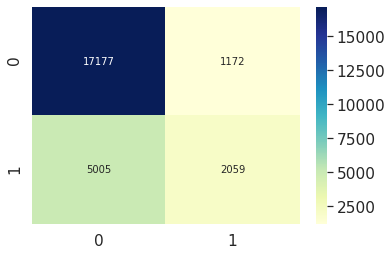

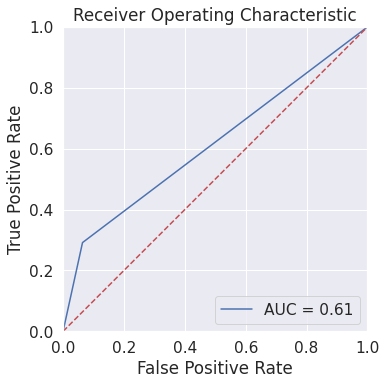

In [34]:
y_pred = tfidf_RF_model.predict(tfidf_test)
display_results(y_pred, y_test)

## Tokenisation with BERT

### Load the model and tokeniser

In [27]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,
                                                    transformers.DistilBertTokenizer,
                                                    'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Embedding Retrieval

In [28]:
def get_bert_embeddings(bert_model, data, batch_size):

    # set device and lambda function for classification token retrieval
    device = torch.device("cuda")
    get_cls_token_embeddings = lambda x: x[0][:, 0, :].squeeze()
    bert_embeddings = []  # initialise embeddings

    for i in range(batch_size, data.shape[0] + batch_size, batch_size):
    
        if i % 100 == 0:
            print("Batch", i)

        # tokenise
        tokenized = tokenizer(list(data['Headline'][i - batch_size:i]), list(data['articleBody'][i - batch_size:i]),\
                          padding='max_length', truncation=True, return_tensors="pt")
        
        # get input ids and set to device
        tokenized_text = tokenized['input_ids']
        tokenized_text = tokenized_text.to(device)

        # calculate embeddings and retrieve cls token embedding
        with torch.no_grad():
            word_embeddings = bert_model(tokenized_text)
        cls_token_embeddings = get_cls_token_embeddings(word_embeddings)

        # append to total embeddings
        if bert_embeddings == []:
            bert_embeddings = cls_token_embeddings
        else:
            bert_embeddings = torch.cat((bert_embeddings, cls_token_embeddings), 0)

        # clear cache and GPU memory
        del word_embeddings
        torch.cuda.empty_cache()

    return bert_embeddings

In [36]:
device = torch.device("cuda")
bert_model = bert_model.to(device)
batch_size = 256

print("===Training Set===")
bert_train = get_bert_embeddings(bert_model, X_train, batch_size)
torch.save(bert_train, main_path + 'bert_train.pt')

print("===Validation Set===")
bert_val = get_bert_embeddings(bert_model, X_val, batch_size)
torch.save(bert_val, main_path + 'bert_val.pt')

print("===Testing Set===")
bert_test = get_bert_embeddings(bert_model, X_test, batch_size)
torch.save(bert_test, main_path + 'bert_test.pt')

===Training Set===
Batch 6400
Batch 12800
Batch 19200
Batch 25600
Batch 32000
Batch 38400
===Validation Set===
Batch 6400
===Testing Set===
Batch 6400
Batch 12800
Batch 19200
Batch 25600


In [37]:
# load, detach from GPU, and convert to numpy arrays
bert_train = torch.load(main_path + 'bert_train.pt').detach().cpu().numpy()
bert_val = torch.load(main_path + 'bert_val.pt').detach().cpu().numpy()
bert_test = torch.load(main_path + 'bert_test.pt').detach().cpu().numpy()

### Train Random Forest (RF) Classifier using BERT Embeddings and display results

In [43]:
bert_RF_model = RandomForestClassifier(random_state=0, max_features=115).fit(bert_train, y_train)
bert_RF_model.score(bert_test, y_test)

0.6911816786683981

              precision    recall  f1-score   support

           0       0.74      0.88      0.81     18349
           1       0.39      0.19      0.26      7064

    accuracy                           0.69     25413
   macro avg       0.56      0.54      0.53     25413
weighted avg       0.64      0.69      0.65     25413



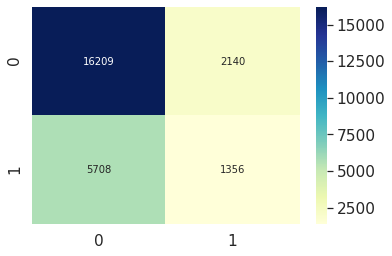

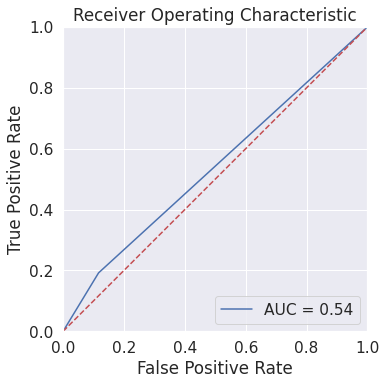

In [44]:
y_pred = bert_RF_model.predict(bert_test)
display_results(y_pred, y_test)

## Deep Learning Models

### Train a Multi-Layer Perceptron (MLP) on TF-IDF Embeddings

#### Define the MLP

In [94]:
tfidf_MLP = Sequential()
tfidf_MLP.add(Dense(256, activation='relu', input_dim=1000))
tfidf_MLP.add(Dense(128, activation='relu'))
tfidf_MLP.add(Dense(64, activation='relu'))
tfidf_MLP.add(Dense(1, activation='sigmoid'))
tfidf_MLP.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])
print(tfidf_MLP.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 256)               256256    
_________________________________________________________________
dense_65 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_66 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 65        
Total params: 297,473
Trainable params: 297,473
Non-trainable params: 0
_________________________________________________________________
None


#### Train the MLP

In [95]:
batch_size = 32
tfidf_MLP.fit(tfidf_train, y_train, batch_size=batch_size,
        epochs=10, validation_data=(tfidf_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 5s 3ms/step - loss: 0.3258 - accuracy: 0.8544 - val_loss: 0.0542 - val_accuracy: 0.9802
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0221 - accuracy: 0.9923 - val_loss: 0.0434 - val_accuracy: 0.9836
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0106 - accuracy: 0.9966 - val_loss: 0.0410 - val_accuracy: 0.9870
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.0362 - val_accuracy: 0.9871
Epoch 5/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.0357 - val_accuracy: 0.9886
Epoch 6/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0405 - val_accuracy: 0.9892
Epoch 7/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.0417 - val_accuracy:

### Display Results of MLP on Related/Unrelated Classification

              precision    recall  f1-score   support

           0       0.86      0.76      0.80     18349
           1       0.52      0.67      0.58      7064

    accuracy                           0.73     25413
   macro avg       0.69      0.71      0.69     25413
weighted avg       0.76      0.73      0.74     25413



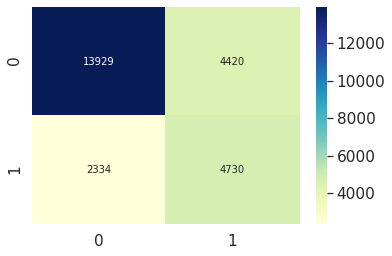

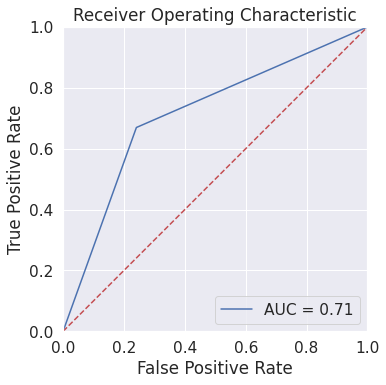

In [96]:
y_pred = (tfidf_MLP.predict(tfidf_test) > 0.5).astype("int32")
display_results(y_pred, y_test)

### Train a Long Short Term Memory (LSTM) model on BERT Embeddings

In [114]:
# https://stackoverflow.com/questions/62281260/how-to-use-cnn-and-lstm-for-nlp-with-bert-embeddings
reshaped_bert_train = bert_train.reshape(-1, 768, 1)
reshaped_bert_val = bert_val.reshape(-1, 768, 1)

bert_LSTM = Sequential()
bert_LSTM.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(768, 1)))
bert_LSTM.add(Bidirectional(LSTM(units=32)))
bert_LSTM.add(Dense(64, activation='relu'))
bert_LSTM.add(LeakyReLU(alpha=0.05))
bert_LSTM.add(Dense(32, activation='relu'))
bert_LSTM.add(LeakyReLU(alpha=0.05))
bert_LSTM.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=0.001)

bert_LSTM.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'])
bert_LSTM.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 768, 128)          33792     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_77 (Dense)             (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 1)               

### Train the LSTM

In [113]:
batch_size = 32
unrelated, related = np.bincount(train_total_data['Relevance'])
total = unrelated + related

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

unrelated_weight = (1 / unrelated)*(total)/2.0 
related_weight = (1 / related)*(total)/2.0
class_weights = {0: unrelated_weight, 1: related_weight}

model_save_file = main_path + data_folder_name + "bert_LSTM.hdf5"
checkpoint = ModelCheckpoint(model_save_file, monitor='loss', verbose=1,
    save_best_only=True, mode='auto', save_freq=1250)

history = bert_LSTM.fit(reshaped_bert_train, y_train, batch_size=batch_size,
                        epochs=50, validation_data=(reshaped_bert_val, y_val),
                        callbacks=[checkpoint], class_weight=class_weights)

/content/drive/My Drive/University Work/Year 4/Natural Language Processing/data/bert_LSTM.hdf5
Epoch 1/50
1000/1250 [=======================>......] - ETA: 33s - loss: 0.6920 - accuracy: 0.5484
Epoch 00001: loss improved from inf to 0.69198, saving model to /content/drive/My Drive/University Work/Year 4/Natural Language Processing/data/bert_LSTM.hdf5
1250/1250 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.5856

KeyboardInterrupt: ignored

### Display Results of LSTM on Related/Unrelated Classification

              precision    recall  f1-score   support

           0       0.78      0.55      0.65     18349
           1       0.34      0.60      0.43      7064

    accuracy                           0.56     25413
   macro avg       0.56      0.57      0.54     25413
weighted avg       0.66      0.56      0.59     25413



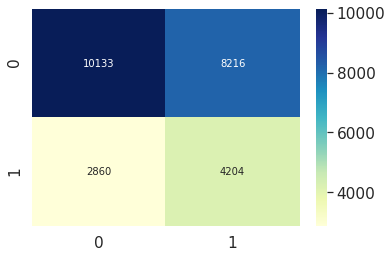

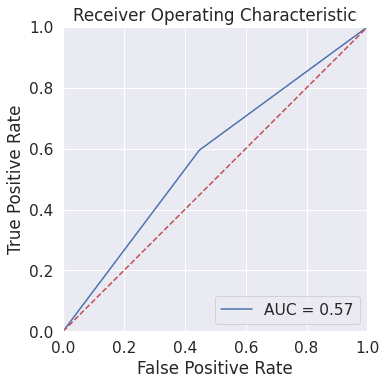

In [99]:
reshaped_bert_test = bert_test.reshape(-1, 768, 1)
y_pred = (bert_LSTM.predict(reshaped_bert_test) > 0.5).astype("int32")
display_results(y_pred, y_test)